In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import (t, norm, mannwhitneyu)

# ___Comparing Means for Two Independent Samples___
----------------------------

In [2]:
nhanes = pd.read_csv("../data/nhanes_2015_2016.csv", usecols = ["RIDRETH1", "RIAGENDR", "RIDAGEYR", "BPXSY2"]).dropna(axis = 0)

## ___Q. Considering African American adults living in US in 2015 - 2016, did males and females have a significantly different mean systolic blood pressure?___

In [3]:
bpress = nhanes.BPXSY2[(nhanes.RIDRETH1 == 4) & (nhanes.RIDAGEYR > 18)]
bpress_m = nhanes.BPXSY2[(nhanes.RIDRETH1 == 4) & (nhanes.RIDAGEYR > 18) & (nhanes.RIAGENDR == 1)]
bpress_f = nhanes.BPXSY2[(nhanes.RIDRETH1 == 4) & (nhanes.RIDAGEYR > 18) & (nhanes.RIAGENDR == 2)]

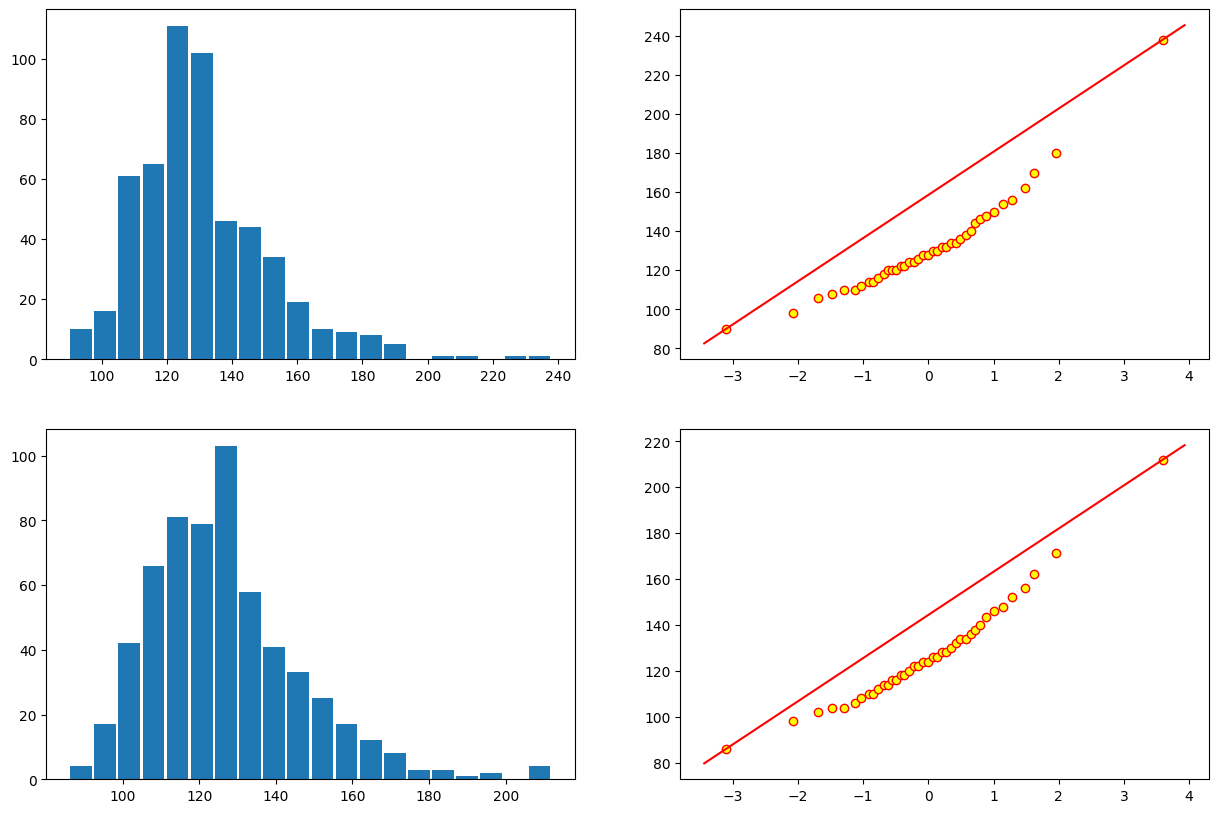

In [8]:
fig, ((axes_0, axes_1), (axes_2, axes_3)) = plt.subplots(ncols = 2, nrows = 2)
fig.set_size_inches(15, 10)

x = np.random.normal(size = 1000)
q = np.linspace(0, 1, num = 40)
qnorm = np.quantile(x, q)

axes_0.hist(bpress_m, bins = 20, rwidth = 0.9)
axes_2.hist(bpress_f, bins = 20, rwidth = 0.9)

axes_1.scatter(qnorm, np.quantile(bpress_m, q), edgecolor = "red", color = "yellow")
axes_1.plot(axes_1.get_xbound(), axes_1.get_ybound(), color = "red")
axes_3.scatter(qnorm, np.quantile(bpress_f, q), edgecolor = "red", color = "yellow")
axes_3.plot(axes_3.get_xbound(), axes_3.get_ybound(), color = "red")

plt.show()

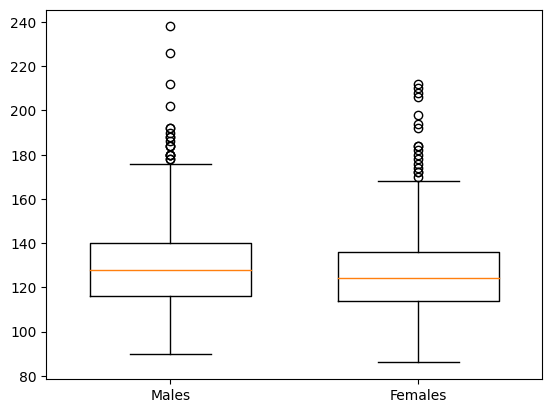

In [10]:
plt.boxplot([bpress_m, bpress_f], labels = ["Males", "Females"], widths = 0.65)
plt.show()

In [17]:
ssize_m, ssize_f = bpress_m.size, bpress_f.size
ssize_m, ssize_f

(544, 599)

In [18]:
bpm, bpf = bpress_m.mean(), bpress_f.mean()
bpm, bpf

(131.00735294117646, 126.68113522537563)

## ___Using Confidence Intervals___
------------

In [19]:
# Formulate a 95% confidence interval for the difference between the male and female population systolic blood pressures?
# Best estimate is the difference between the sample means.

best_est = bpm - bpf
best_est

4.326217715800837

In [20]:
# confidence interval = best estimate +- margin of error.
# margin of error = multiplier * standard error

# Since this is about means, we'll use the t multiplier.

tscore = t.ppf(0.975, df = min(ssize_m, ssize_f) - 1)
tscore

1.9643423968425016

### __Assuming unequal variances (Unpooled approach).__

# ___$stderr_{unpooled} = \frac{S_m}{\sqrt{n_m}} + \frac{S_f}{\sqrt{n_f}}$___

In [21]:
bpress_m.std(), bpress_f.std()

(20.462424377291704, 19.602833084272387)

In [22]:
# standard error (using unpooled approach, assuming the variances are more/less equal)

bpress_m.var(), bpress_f.var()

(418.7108113963818, 384.27106492984404)

In [23]:
stderr_m = bpress_m.std() / np.sqrt(ssize_m)
stderr_f = bpress_f.std() / np.sqrt(ssize_f)

stderr_m, stderr_f

(0.8773192073227774, 0.8009500462017536)

In [24]:
stderr_comb = stderr_m + stderr_f
stderr_comb

1.678269253524531

In [25]:
# margin of error

moerr = tscore * stderr_comb
moerr

3.296695448015453

In [26]:
# 95% confidence interval

lcb_unpooled, ucb_unpooled = best_est - moerr, best_est + moerr
lcb_unpooled, ucb_unpooled

(1.0295222677853841, 7.62291316381629)

### __Assuming equal variances (Pooled approach).__

# $stderr_{pooled} = \sqrt{\frac{(n_m - 1)s_m^2 + (n_f - 1)s_f^2}{n_m + n_f - 2}(\frac{1}{n_m}+\frac{1}{n_f})}$

In [27]:
stderr_pooled = np.sqrt(((bpress_m.var() * (ssize_m - 1)) + (bpress_f.var() * (ssize_f - 1))) / (ssize_m + ssize_f - 2) *\
                        ((1 / ssize_m) + (1 / ssize_f)))
stderr_pooled

1.185492268669468

In [28]:
stderr_comb

1.678269253524531

In [29]:
# There's a small difference in standard errors calculated using the pooled and unpooled approaches.

moerr_pooled = tscore * stderr_pooled
moerr_pooled

2.3287127244764374

In [30]:
lcb_pooled, ucb_pooled = best_est - moerr_pooled, best_est + moerr_pooled
lcb_pooled, ucb_pooled

(1.9975049913243996, 6.654930440277274)

In [32]:
# Neither of the pooled or unpooled confidence intervals include 0.
# Inclusion of 0 in confidence intervals will imply that it is possible for the best estimate to be 0.
# i.e males and females populations to have the same systolic blood pressure.

# According to our results, that possibility has been ruled out irrevocably.

print(f"Pooled confidence interval: {lcb_pooled}, {ucb_pooled}")
print(f"Unooled confidence interval: {lcb_unpooled}, {ucb_unpooled}")

Pooled confidence interval: 1.9975049913243996, 6.654930440277274
Unooled confidence interval: 1.0295222677853841, 7.62291316381629


## ___Using Hypothesis Testing___
-------------------

In [33]:
# Significance level 0.05 (5%)

# Null hypothesis: There is no significant difference between the systolic blood pressures of african american male and female populations aged 18+ 
# living in the US in 2015 - 2016

# Alternative hypothesis: The population mean systolic blood pressures are significantly different for  african amnerican males and females aged 18+
# living in the US in between 2015 - 2016

In [34]:
# Our best estimate is the difference in sample blood pressures

best_est = bpress_m.mean() - bpress_f.mean()
best_est

4.326217715800837

In [35]:
# hypothesized estimate is 0.0

# standard error, unpooled approach

stderr_m = bpress_m.std() / np.sqrt(ssize_m)
stderr_f = bpress_f.std() / np.sqrt(ssize_f)

stderr_m, stderr_f

(0.8773192073227774, 0.8009500462017536)

In [36]:
stderr_comb = stderr_m + stderr_f
stderr_comb

1.678269253524531

In [44]:
# test statistic

tstat_unpooled = (best_est - 0) / stderr_comb
tstat_unpooled

2.5777852431696244

In [46]:
p_unpooled = 2 * (1 - t.cdf(tstat, df = min(ssize_m, ssize_f) - 1))
p_unpooled

0.010206048959519265

In [47]:
# standard error, pooled approach,

stderr_pooled = np.sqrt(((bpress_m.var() * (ssize_m - 1)) + (bpress_f.var() * (ssize_f - 1))) / (ssize_m + ssize_f - 2) *\
                        ((1 / ssize_m) + (1 / ssize_f)))
stderr_pooled

1.185492268669468

In [53]:
df_pooled = ssize_m + ssize_f - 2
df_pooled

1141

In [48]:
tstat_pooled = (best_est - 0.0) / stderr_pooled
tstat_pooled

3.6493006577397153

In [55]:
p_pooled = 2 * (1 - t.cdf(tstat_pooled, df = df_pooled))
p_pooled

0.0002748459106509671

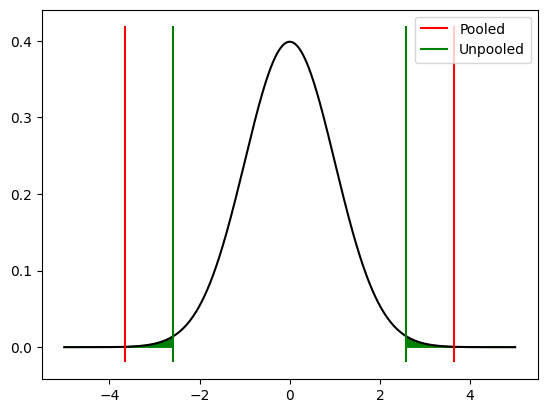

In [51]:
x = np.linspace(-5, 5, num = 1000)
tpdfs = t.pdf(x, df = x.size - 1)

fig, axes = plt.subplots()
axes.plot(x, tpdfs, color = "black")
ymin, ymax = axes.get_ybound()
axes.vlines([-tstat_pooled, tstat_pooled], ymin, ymax, color = "red", label = "Pooled")
axes.vlines([-tstat_unpooled, tstat_unpooled], ymin, ymax, color = "green", label = "Unpooled")

axes.fill_between(x = x, y1 = 0, y2 = tpdfs, where = (x <= -tstat_pooled) | (x >= tstat_pooled), color = "red")
axes.fill_between(x = x, y1 = 0, y2 = tpdfs, where = (x <= -tstat_unpooled) | (x >= tstat_unpooled), color = "green")
axes.legend()
plt.show()

In [56]:
p_pooled, p_unpooled

(0.0002748459106509671, 0.010206048959519265)

In [57]:
# Both of our p value is less than the significance level of 0.05
# So, we can reject the Null hypothesis.

# There's enough evidence that the population mean systolic blood pressure of african american males and females aged 18+ living in the US
# in 2015 - 2016 are not the same.

## ___What if the Normality Assumption Did not hold?___
-------------

In [59]:
# If we are not convinced that the samples of males and females did not come from two independent normal distributions,
# we could use a non-parametric test, instead of tests that leverage the CLT, which needs the normality as a prerequisite.
# Non-parametric tests do not make such assumptions.

# The non-parametric equivalent of the two sample t test is the Mann-Whitney test, which compares locations of distributions using medians.
# The conclusions of Mann-Whitney test will be robust in face of potential violations of normality.

In [61]:
mannwhitneyu(bpress_m, bpress_f, alternative = "two-sided")

MannwhitneyuResult(statistic=184611.5, pvalue=9.902929327654964e-05)

In [ ]:
# Again, we get a very low p value that is way smaller than the significance level of 0.05
# So, we'll reject the Null hypothesis.